In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(99)


In [74]:
dataFrame = pd.read_csv('/content/drive/My Drive/data/viettri_quality.csv', index_col='date')

In [75]:
dataFrame

,pm25,pm10,o3,no2,so2,co
date,,,,,,
3/1/2019,44,17,29,2,9,4
3/2/2019,65,37,27,4,12,4
3/3/2019,81,38,2,1,1,2
3/4/2019,51,24,21,4,8,1
3/5/2019,43,7,23,1,12,4
...,...,...,...,...,...,...
5/28/2024,38,24,35,1,15,5
5/29/2024,38,17,41,7,15,10
5/30/2024,28,8,11,1,15,1


In [76]:
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0) # Handling missing values, fill with 0 instead of removing
dataFrame = pd.DataFrame(imputer.fit_transform(dataFrame), columns=dataFrame.columns)
dataFrame = dataFrame.reset_index(drop=True)
# Applying feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(dataFrame.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=list(dataFrame.columns))
target_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled[['pm25']] = target_scaler.fit_transform(dataFrame[['pm25']].to_numpy())
df_scaled = df_scaled.astype(float)

In [77]:
# Single step dataset preparation
def singleStepSampler(df, window):
	xRes = []
	yRes = []
	for i in range(0, len(df) - window):
		res = []
		for j in range(0, window):
			r = []
			for col in df.columns:
				r.append(df[col][i + j])
			res.append(r)
		xRes.append(res)
		yRes.append(df[['pm25']].iloc[i + window].values)
	return np.array(xRes), np.array(yRes)


In [78]:
# Dataset splitting
SPLIT = 0.9
(xVal, yVal) = singleStepSampler(df_scaled, 20)
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]

In [79]:
n_forecast = 5

In [80]:
model_gru = keras.Sequential()
model_gru.add(keras.layers.GRU(30, input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(keras.layers.Dropout(0.2))
model_gru.add(keras.layers.Dense(n_forecast, activation='linear'))
model_gru.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
model_gru.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 30)                3420      
                                                                 
 dropout_4 (Dropout)         (None, 30)                0         
                                                                 
 dense_4 (Dense)             (None, 5)                 155       
                                                                 
Total params: 3575 (13.96 KB)
Trainable params: 3575 (13.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [81]:
history = model_gru.fit(X_train, y_train, epochs=20)

Epoch 1/20
54/54 [==============================] - 3s 12ms/step - loss: 0.0513 - MAE: 0.1620
Epoch 2/20
54/54 [==============================] - 1s 15ms/step - loss: 0.0261 - MAE: 0.1195
Epoch 3/20
54/54 [==============================] - 1s 14ms/step - loss: 0.0223 - MAE: 0.1060
Epoch 4/20
54/54 [==============================] - 1s 14ms/step - loss: 0.0214 - MAE: 0.1022
Epoch 5/20
54/54 [==============================] - 1s 15ms/step - loss: 0.0196 - MAE: 0.0973
Epoch 6/20
54/54 [==============================] - 1s 15ms/step - loss: 0.0198 - MAE: 0.0965
Epoch 7/20
54/54 [==============================] - 1s 16ms/step - loss: 0.0194 - MAE: 0.0954
Epoch 8/20
54/54 [==============================] - 1s 12ms/step - loss: 0.0186 - MAE: 0.0917
Epoch 9/20
54/54 [==============================] - 1s 10ms/step - loss: 0.0184 - MAE: 0.0914
Epoch 10/20
54/54 [==============================] - 1s 10ms/step - loss: 0.0180 - MAE: 0.0897
Epoch 11/20
54/54 [==============================] - 1s 10m

In [82]:
# Reload the data with the date index
dataFrame = pd.read_csv('/content/drive/My Drive/data/hanoi_quality.csv') # Assuming the CSV file contains a 'Date' column
dataFrame['date'] = pd.to_datetime(dataFrame['date'])
dataFrame.set_index('date', inplace=True)

# Forecast Plot with Dates on X-axis
predicted_values = model_gru.predict(X_test)

d = {
	'Predicted_pm25': predicted_values[:, 0],
 'Actual_pm25': y_test[:, 0],
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):] # Assigning the correct date index


6/6 [==============================] - 1s 4ms/step


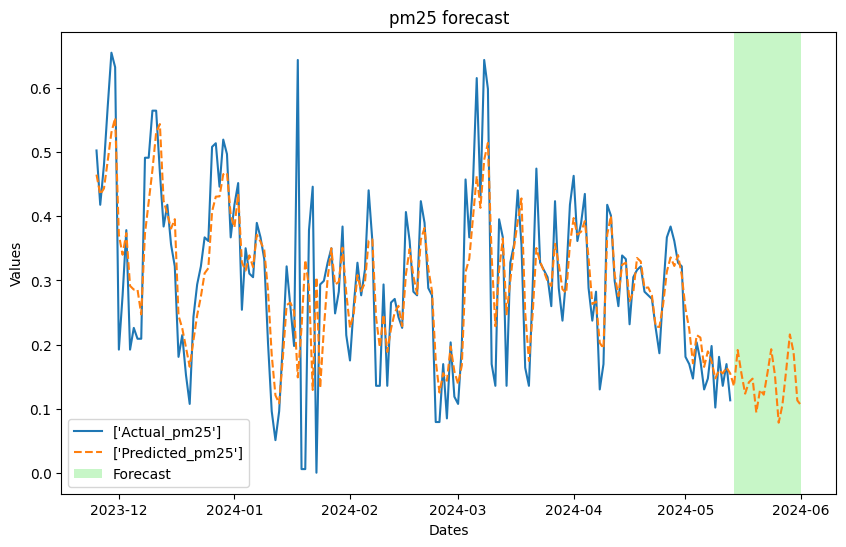

In [83]:
fig, ax = plt.subplots(figsize=(10, 6))
# highlight the forecast
highlight_start = int(len(d) * 0.9)
highlight_end = len(d) - 1 # Adjusted to stay within bounds
# Plot the actual values
plt.plot(d[['Actual_pm25']][:highlight_start], label=['Actual_pm25'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_pm25']], label=['Predicted_pm25'], linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('pm25 forecast')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()

In [84]:
predicted_values

array([[0.46514067, 0.46861118, 0.47251686, 0.4582464 , 0.4651003 ],
       [0.43427625, 0.4368937 , 0.44664887, 0.43058497, 0.43070483],
       [0.44361052, 0.4465984 , 0.4487616 , 0.4438473 , 0.44778484],
       [0.4862143 , 0.48950696, 0.4827744 , 0.48567754, 0.49412763],
       [0.5309622 , 0.537124  , 0.5389559 , 0.53002447, 0.5330313 ],
       [0.5537249 , 0.55943656, 0.5553982 , 0.5486143 , 0.5563229 ],
       [0.37120757, 0.3685302 , 0.37762943, 0.3677497 , 0.36568224],
       [0.34007055, 0.33979213, 0.35771415, 0.3376163 , 0.34170288],
       [0.3738275 , 0.37987816, 0.38631645, 0.37002197, 0.3773455 ],
       [0.29158193, 0.29233426, 0.29795873, 0.28779024, 0.29333723],
       [0.28577322, 0.28683138, 0.2886886 , 0.28127214, 0.2897206 ],
       [0.28569177, 0.28531393, 0.2787996 , 0.27602986, 0.29212886],
       [0.24708433, 0.24533312, 0.25538597, 0.2450825 , 0.2459295 ],
       [0.37304828, 0.3746537 , 0.3761752 , 0.36506683, 0.381548  ],
       [0.42285874, 0.42440575, 0.

In [85]:
predicted_values_90 = predicted_values[:18]

In [86]:
pm25_scaler = target_scaler
# Perform the inverse transformation on the scaled pm25 data
predicted_values_90 = pm25_scaler.inverse_transform(predicted_values_90)

# Check the DataFrame to see the reversed pm25 values
print(predicted_values_90)

[[ 83.329895  83.944176  84.63548   82.10961   83.322754]
 [ 77.8669    78.330185  80.05685   77.21354   77.23476 ]
 [ 79.51906   80.04792   80.4308    79.560974  80.25792 ]
 [ 87.05993   87.64273   86.45107   86.96493   88.460594]
 [ 94.980316  96.070946  96.3952    94.81434   95.34654 ]
 [ 99.00931  100.02028   99.30549   98.10474   99.469154]
 [ 66.703735  66.22985   67.84041   66.0917    65.72575 ]
 [ 61.192486  61.143208  64.31541   60.758083  61.48141 ]
 [ 67.167465  68.238434  69.37801   66.49389   67.79015 ]
 [ 52.61      52.743164  53.738697  51.938873  52.92069 ]
 [ 51.58186   51.769154  52.09788   50.785168  52.280544]
 [ 51.567444  51.500565  50.347527  49.857285  52.706806]
 [ 44.73393   44.423965  46.203316  44.3796    44.529522]
 [ 67.02954   67.313705  67.58301   65.61683   68.534   ]
 [ 75.846     76.11982   75.287155  74.46173   76.32916 ]
 [ 84.55726   85.64036   85.79658   83.643005  84.96096 ]
 [ 95.02644   95.71584   94.35843   94.40183   96.0614  ]
 [ 97.29149   

In [87]:
predicted_values_90 = np.concatenate(predicted_values_90, axis=0)

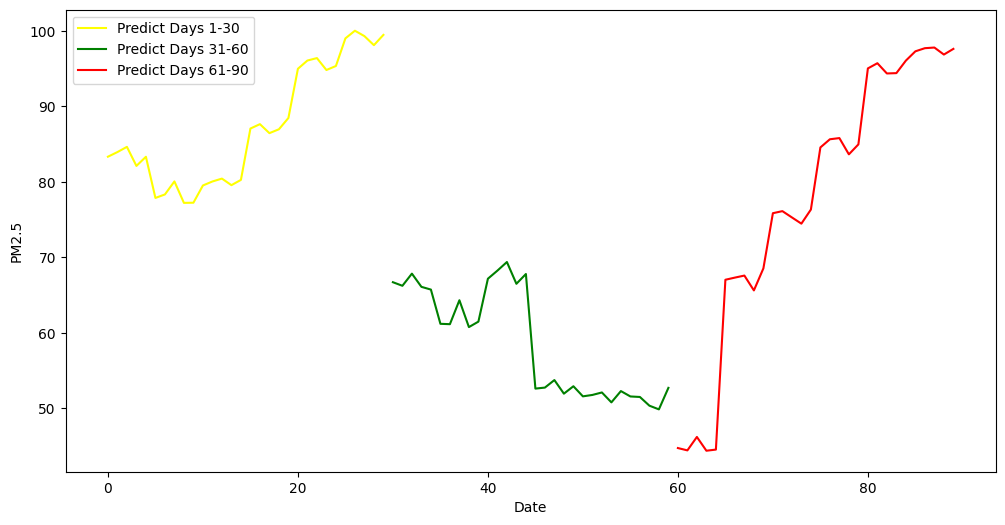

In [88]:
plt.figure(figsize=(12, 6))

dates = np.arange(1, 91)
data = pd.DataFrame({'Date': dates, 'predicted_values_90': predicted_values_90})

plt.plot(data['predicted_values_90'][:30], color='yellow', label='Predict Days 1-30')
plt.plot(data['predicted_values_90'][30:60], color='green', label='Predict Days 31-60')
plt.plot(data['predicted_values_90'][60:], color='red', label='Predict Days 61-90')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.legend()

# Show plot
plt.show()

In [89]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
if predicted_values.ndim == 1:
    predicted_values = predicted_values.reshape(-1, 1)

# Inverse transform the predicted values
predicted_values_all = pm25_scaler.inverse_transform(predicted_values)

# Check the shape after inverse transformation
print("Shape of y_test:", y_test.shape)
print("Shape of predicted_values_all:", predicted_values_all.shape)
# Aggregate predictions to match the shape of y_test
predicted_values_aggregated = np.mean(predicted_values_all, axis=1, keepdims=True)

# Calculate the RMSE, MAE, and MAPE
rmse = mean_squared_error(y_test, predicted_values_aggregated, squared=False)
mae = mean_absolute_error(y_test, predicted_values_aggregated)
mape = mean_absolute_percentage_error(y_test, predicted_values_aggregated)

# Print the results
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)


Shape of y_test: (190, 1)
Shape of predicted_values_all: (190, 5)
RMSE: 54.63530482025302
MAE: 51.5597822590311
MAPE: 1333271597496758.2
